<h1 style="text-align: center;">Topological Data Analysis with Gudhi for Dynamical Systems, a tutorial</h1>

**Author:** [Théo Lacombe](https://tlacombe.github.io), Université Gustave Eiffel

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\FF}{\mathcal{F}}$
$\newcommand{\XX}{\mathcal{X}}$
$\newcommand{\Z}{\mathbb{Z}}$
$\newcommand{\dgm}{\mathrm{dgm}}$
$\newcommand{\Cech}{\text{\v Cech}}$

Outline : 

- **I. Introduction**
- **II. Topological Data Analysis (TDA)**
    1. A brief overview of mathematical foundations of TDA
    2. A brief overview of algorithmic foundations of TDA
    <!--3. Persistent Homology on point clouds-->
    3. Persistent Homology for time series and dynamical systems
    4. Vectorization of topological descriptors
    5. Topological Optimization
- **III. Gudhi**
    1. Overall presentation of Gudhi
    2. The SimplexTree interface
    3. Extracting persitence diagrams
    4. Topological Optimization with Gudhi
    5. Contributing to Gudhi
- **IV. Your turn: experiment TDA on Time Series**
- **V. To go further: some questions before the MRC.**

# I. Introduction

This notebook provides an introduction to Topological Data Analysis from the practionner side: our ultimate goal is to make you ready to implement the creative ideas you will develop before, during and after the MRC-week. 

$\bullet$ Section II. introduces Topological Data Analysis (TDA). It does not pretend to be comprehensive, but rather hopefully gives you the right tools to address some of the questions that will be asked during the MRC. The participant that would be already knowledgeable about TDA can skip some subsections therein (a priori, they go in increasing order of technicality: section II.1 is very standard and "well-known" among TDA practitionners, while II.6 relies on very recent research!). Note that it does not pretend to be beyond reproach in terms of mathematical rigor; the goal is essentially to set up your intuition. Understanding all details requires to read paper/books/lecture notes, which is worth it, but would make this (already long) tutorial way too long!

$\bullet$ Section III. presents the TDA library `Gudhi`. Here as well, we do not present all the functionalities provided by this library, but rather try to insist on the features that should be useful for the program. Of course, feel free to look by yourself to the other options provided by the library!

$\bullet$ Section IV. is an illustration of the use of TDA + `Gudhi` in the context of time series and dynamical systems. This is inspired from a presentation of [Mathieu Carrière](https://www-sop.inria.fr/members/Mathieu.Carriere/).

$\bullet$ Section V. proposes some open questions that you may start thinking about before the program. 

We will work using `Python`. 

Why? The main reason is that the TDA library we will use (namely, `Gudhi`, but this holds for many other TDA libraries) provides a `C++` and a `Python` interface. While `C++` is a nice and efficient language, it is not as "plug-and-play" as `Python` is. Furthermore, many (recent) functionnalities in `Gudhi` have only been implemented in `Python` (it is interesting to note that the core machinery is implemented in `C++` though). As we plan to make use of them, `Python` turns out to be the natural choice for a dynamic and interactive research program!

The second natural question is then: why `Gudhi`?

First and foremost, this is the library the author of this notebook is familiar with (as being the developer of some tools proposed therein). This is an **open-source** project mostly led by the [team Datashape](https://www.inria.fr/fr/datashape), but be aware that **you** can contribute to Gudhi by creating a [_pull request_](https://github.com/GUDHI/gudhi-devel/pulls) (PR)--details on how to contribute will be provided at the end of section III. PR should satisfy some constraints (be well documented, include tests, etc.) and are then reviewed by the editorial board of Gudhi, modified accordingly, and eventually merged (accepted) to be incorporating in the next version release. Having contributions to an open-source library is a valuable asset when applying to both academic or industrial positions!

Other good reasons to use `Gudhi` is that, as being actively developed by a team of researchers really involved in Topological Data Analysis, the library provides some unique modern tools, including some tools related to _Topological Optimization_.

**Setup:** To make sure that everything work as expected, we suggest that you use the same `environment` as the one used to develop this tutorial. <!--The major limitation is that the latest version of `tensorflow` (at the time of writing) is `2.4.1` and only supports `numpy 1.19.x` (while `numpy` is now at version `1.24.x`).-->
To do so, hopefully you may just need to run
```
conda env create -f tda_tutorial.yml
```
from a terminal. 

In any case, you should be able to run the following cells without error.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
from gudhi.tensorflow import RipsLayer
import tensorflow as tf
from tqdm.notebook import tqdm

import utils as u

print("Version of Gudhi you are using: (should be at least 3.8.0): %s" %gd.__version__)
print("Version of tensorflow (should be at least 2.4): %s " %tf.__version__)

Version of Gudhi you are using: (should be at least 3.8.0): 3.8.0
Version of tensorflow: 2.13.0


Note also that the figures and some handy functions are implemented in the companion file `utils.py`. You do not need to check this file to run the notebook, but this can be instructive in some situations! Beware, it is not very well documented. 

A convenient aspect is that the figure being generated on-the-fly, the tutorial remain fairly light.

**Some exercises:** The tutorial naturally contains few exercises here and there. If you are unsure about your answer and really want to check if your understanding is correct, you can send an email to `theo.lacombe@univ-eiffel.fr`.

**Some references:** Though the TDA literature is evolving quite fast, if you want to go further and learn more generally about TDA, you may be interested in looking at the following papers/books (and many other):
- [An Introduction to Topological Data Analysis: Fundamental and Practical Aspects for Data Scientists](https://www.frontiersin.org/articles/10.3389/frai.2021.667963/full?ref=graphusergroup.com), Chazal and Michel. 
- [A roadmap for the computation of persistent homology](https://link.springer.com/content/pdf/10.1140/epjds/s13688-017-0109-5.pdf), Otter et al.
- [Computational Topology: an Introduction](https://www.maths.ed.ac.uk/~v1ranick/papers/edelcomp.pdf), Edelsbrunner and Harer (based on [these lecture notes](https://courses.cs.duke.edu/fall06/cps296.1/), which can be interesting in themselves.). 

From the computational / implementation perspective, the (`Python`) documentation of `Gudhi` can be found [here](https://gudhi.inria.fr/python/latest/). Many very nice tutorials for Gudhi are available [here](https://github.com/GUDHI/TDA-tutorial). Let us also mention a very nice overview of TDA libraries (and smaller github repositories) [here](https://cat-list.github.io/).

# II. Topological data Analysis

## 1. A brief overview of mathematical foundations of TDA

We present in this subsection Topological Data Analysis (TDA) under the lens of (one-dimensional parameter) _persistent homology_ from a (mild) theoretical perspective.

**Topology:** Let us first (very) briefly explain what we mean by _topology_. In a nutshell, the topology of an object (you can typically think of a submanifold of $\R^d$) is a description of its properties that are preserved by homotopy: losely speaking, two objects (shapes) $X$ and $Y$ are homotopic if one can go from $X$ to $Y$ without self-intersecting the shape, nor collapsing the shape.

Note: we will often consider the words "space", "object" or "shape" interchangeably. 

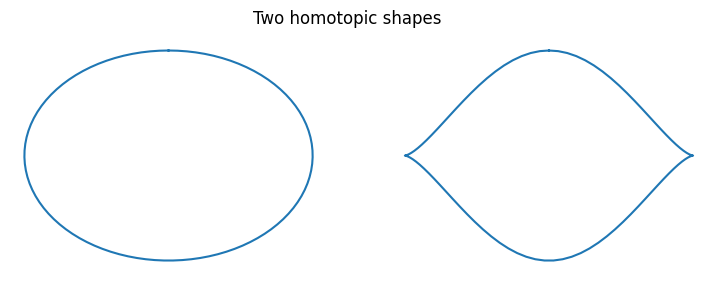

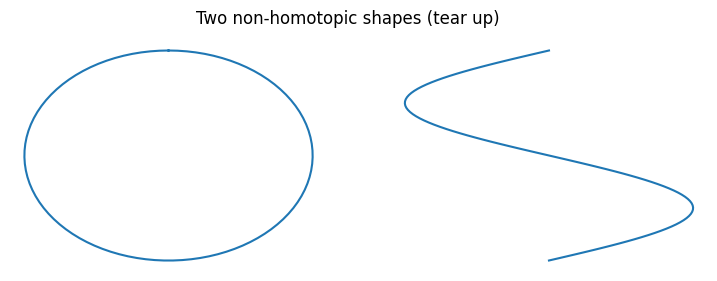

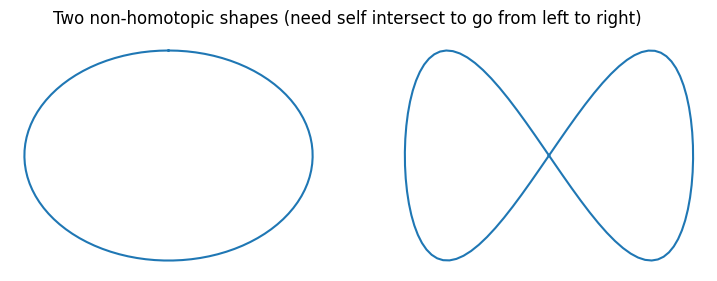

In [3]:
# Run the following cell to have an illustration
u.showcase_homotopy()

Among the properties preserved by homotopic transformations, there are _homology groups_. In a nutshell, for a given space $X$, 
- The Homology group of "dimension 0", denoted by $H_0(X)$ (or $H_0$ if there is no ambiguity), account for _connected components_,
- The gomology group $H_1$ of "dimesion 1" account for _loops_ ,
- $H_2$ account for _cavities_,
- and so on for higher dimensional homology groups, even though visualizing them is harder.

To give you a bit more intuition, it is important to note that topological features (connected components, loops, cavities...) are accounted _up to boundaries_, that is we consider that two features (e.g.~two loops) are equivalent if they are _the boundary of a same face_. For instance, the two "loops" that delimits a cylinder $S^1 \times [0,1]$ (where $S^1$ denote the unit circle in $\R^2$) are the boundary of a same face and are thus equivalent. In particular, loops that are the boundary of some subset of $X$ are "trivial". For instance, the boundary of a disk is trivial. This is how you formalize that, even though you can draw many loops on the surface of a sphere, they all are trivial: there is no "meaningful" loop on a sphere (but there is a cavity! which itself disappear if you consider a ball instead of a sphere). 

Without going deep into the details, homology groups often turn out to be encoded as finite dimensional vector spaces supported on a finite field, that is $H_k = \left(\frac{\Z}{p\Z}\right)^{\beta_k}$, with $p$ prime. The integer $\beta_k$ is called the $k$-th Betti number of $X$, and it is simply _counting_ the number of aforementioned topological features of your object $X$.

For instance, 
- if $X$ is a circle in $\R^2$, one has $\beta_0 = 1$ (one connected component) and $\beta_1 = 1$ (one loop), higher-order $\beta_k$ equal $0$.
- if $X$ is a cylinder in $\R^2$, one has $\beta_0 = 1,\beta_1 = 1,\beta_{k \geq 2} = 0$.
- if $X$ is a sphere in $\R^3$, one has $\beta_0 = 1$, $\beta_1 =0$, and $\beta_2 = 1$ (one cavity); with higher order $\beta_k$ being $0$. 

**<span style="color:blue">Exercise:</span>** Following your intuition, what should be the Betti numbers of
- A [torus](https://en.wikipedia.org/wiki/Torus),
- A cube (not filled-in, i.e. the boundary of $[0,1]^3$).
- The edge of a cube (the boundary of the previous shape).

In an extremely large number of applications though, we never observe true shapes $X$, but rather points $X_n := x_1,\dots,x_n$ sampled on $X$ (typically as realizations of a stochastic process, or some discretization procedure, etc.). Assuming $n$ is large, $X_n$ "looks like" $X$. However, from a topological perspective, the Betti numbers of $X_n$ are always as simple as $\beta_0 = n, \beta_{k \geq 1} = 0$...

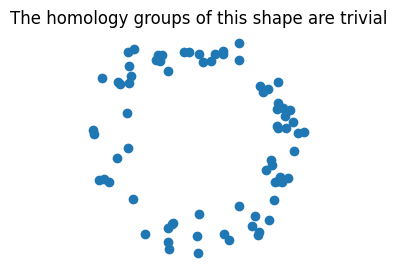

In [4]:
u.showcase_point_cloud_trivial_homology()

Therefore, if we want to estimate the topology of $X$ from a sample $X_n$ on $X$, we must resort on more sophisticated tools... 

This is where Topological Data Analysis, by the mean of _Persistent Homology_, strikes!

**Filtrations:** The starting point is to consider a function 
$$f : \XX \to \R,$$
where $\XX$ is a _topological space_ (typically $\R^d$ or a sub-manifold of $\R^d$). This function is called a _filtration_, because it can be used to somewhat "investigate" the space $\XX$ at different _scale_. We do so by looking at the _sublevel sets_ of $f$ defined for $t \in \R$ as:
$$\FF_t = \{ x \in \XX, f(x) \leq t\}.$$

It is very to check that $s \leq t \Rightarrow \FF_s \subset \FF_t$. 

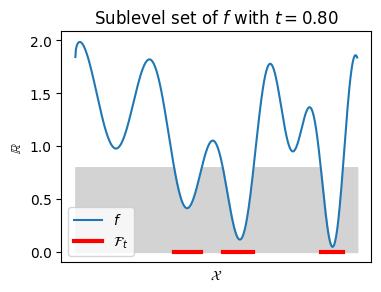

In [5]:
# Showcase the sublevelset of $f$. You can play with the value of "parameter".
# (keep it > 0 for plotting purposes)
u.showcase_sublevel_sets(parameter = 0.8)

A very common situation in TDA is to consider the so-called $\text{\v Cech}$ filtration: consider a finite point cloud $(x_1,\dots,x_n) =: X_n \subset \R^d$. One can define a function $f : \R^d \to \R$ as

$$f(x) = \min_{i = 1,\dots,n} \|x - x_i\|,$$

that is $f(x)$ indicates the distance from $x$ to the point cloud $X_n$. Note that here, $\XX = \R^d$. 


**<span style="color:blue">Exercise:</span>** How to describe (geometrically) the sublevel set of $f$ for the $\Cech$ filtration?


This filtration is very useful in applications because you can prove, losely speaking, results like 

> Assume that $x_1,\dots,x_n$ are iid samples on an underlying (typically unknown) shape $X \subset \R^d$ (sampled with respect from some "nice" density, say uniform). Then, provided $n$ is large enough, there exists some well-chosen parameter $t$ such that the homology of $\FF_t$ coincide with those of $X$ (with high probability, say). 

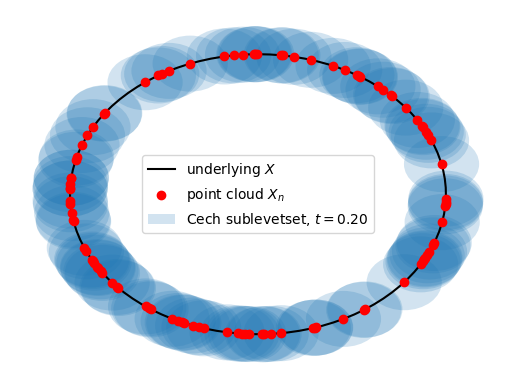

In [6]:
# Illustration of the Cech sublevel set and the above (informal) theorem.
# Unless you've been very unlucky with your sampling, the homology of the Cech 
# sublevelset (lightblue area) should be the same as the one of the underlying shape X
# that is, a circle --> one connected component and one non-trivial loop.

u.showcase_Cech_sublevelset(parameter=0.2)

# You can play with the parameter, if it's too low, you will not see the loop (and even have more than 1
# connected component, if it's too large, the loop structure will be killed (filled in), and your sublevel set
# will have the homology of a disk (that is of a point).

The issue with this kind of results is that when $X$ is unknown, choosing a good $t$ is absolutely non-trivial (those interested can read [this paper](https://projecteuclid.org/journals/electronic-journal-of-statistics/volume-15/issue-2/Minimax-adaptive-estimation-in-manifold-inference/10.1214/21-EJS1934.pdf) for instance). 

The paradigm used in TDA is somewhat simpler: look at _all_ $t \in (-\infty, + \infty)$, and see how the homology groups evolve when $t$ increases!

A core result in TDA, known as the _interval decomposition theorem_, is that under very soft assumptions on $f$ (typically satisfied for the $\text{\v Cech}$ filtration), there is only a _finite_ number of values of $t$ for which the homology groups change. They correspond either to
- values $t_b$ at which a new topological feature appears in $(\FF_t)_t$, called _birth time_.
- values $t_d$ at which an existing topological feature disappears (e.g. a loop gets filled in), called _death time_.

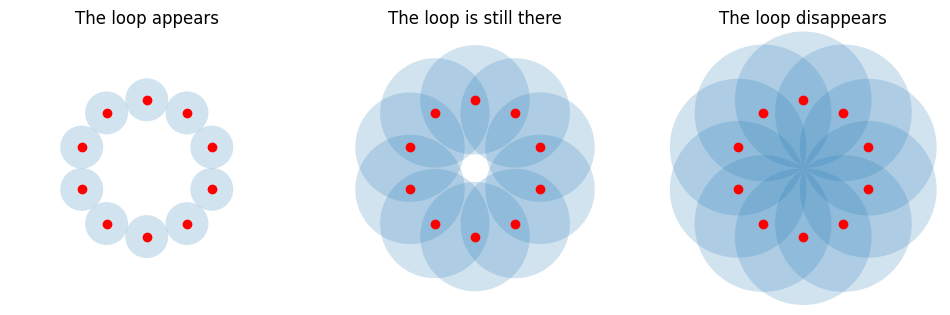

In [7]:
u.showcase_birth_death()

Therefore, the final pipeline reads like this: let $t$ increases from $-\infty$ to $+\infty$ (note: for the $\text{\v Cech}$ filtration, nothing interesting occurs for $t <0$ as $\FF_t = \emptyset$), and record each birth time $t_{b_i}$ at which a $i$-th topological feature (for some homological dimension) appears in $(\FF_t)_t$ and the corresponding death time $t_{d_i} > t_{b_i}$ at which this feature disappears (if this never occurs, we set $t_{d_i} = +\infty$). 

The resulting collection of intervals $(t_{b_i}, t_{d_i})_i$ is called the _persistence diagram_ or _persistence barcode_ of $f : \XX \to \R$ (note: in the context of the $\text{\v Cech}$ filtration, we slightly abuse the terminology and call the resulting object "the diagram of $X_n$"). It will be denoted by $\dgm(f)$ (or $\dgm(X_n)$).

They can be visualized by either plotting bars representing the intervals (barcode representation) or simply representing each intervals as a points in $\R^2$ (note: since the death time is higher than the birth time, points are actually supported on the open half-plane $\{(b,d),\ d > b\}$ above the diagonal $\{b=d\}$). 

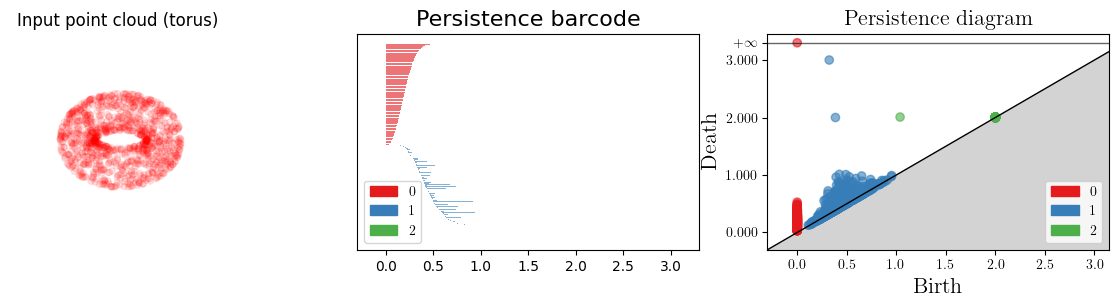

In [8]:
u.showcase_barcode_and_dgm()
# There is a visual artefact which makes the cavity (2-dimensional homological feature) in the Torus hard to see 
# in the barcode representation. 
# The Persistence Diagram representation should often be prefered. 

What is really nice with persistence diagrams/barcodes is that they are _quantitative topological descriptors_: the longer the bar $(t_{b_i}, t_{d_i})$ (or the further away the point from the diagonal), the longer the topological feature _persisted_ through the different scales ("robust" features), while short bars/points close to the diagonal typically account for "noise", in the sense that slightly perturbating $f$ (or $X_n$) could make them disappear. 

From these observations, we can define some sorts of metrics in TDA, often referred to as _Wasserstein distances between persistence diagrams_, denoted by $W$ in the following. A central type of results in TDA are stability theorems which (here again, very roughly) state that

> If $f, g : \XX \to \R$ are close (for, say, the sup-norm), then
> $$ W(\dgm(f),\dgm(g)) \leq \| f - g\|_\infty. $$

In plain text: 

> Similar shapes/spaces/objects shall have similar persistence diagrams.

If $f,g$ are distance functions with respect to two point cloud $X$ and $X'$, then $\|f - g\|_\infty$ becomes the so-called [Hausdorff distance](https://en.wikipedia.org/wiki/Hausdorff_distance) between $X$ and $X'$ (**<span style="color:blue">Exercise:</span>** Prove this claim). 

In particular, if one adds a small perturbation to a point cloud $X$ (e.g. small Gaussian noise), the corresponding persistence diagrams should be close to each other in terms of $W$, which intuitively means that 
- Points far from the diagonal are only slightly moved: robust topological features (that persistence through scale) are stable
- There may be some change close to the diagonal (noise can easily create or destroy "small" topological features). 

<!--Note that the converse implication is not true: persistence diagrams are _invariant_ under some transformations. For instance, in the context of the $\Cech$ filtration, if $\varphi$ is an isometry of $\R^d$ and $X \subset \R^d$ is a compact set (in particular a point cloud), then $\dgm(\varphi(X)) = \dgm(X)$: the (persistent) homology of a shape does not change under isometric transformation. -->

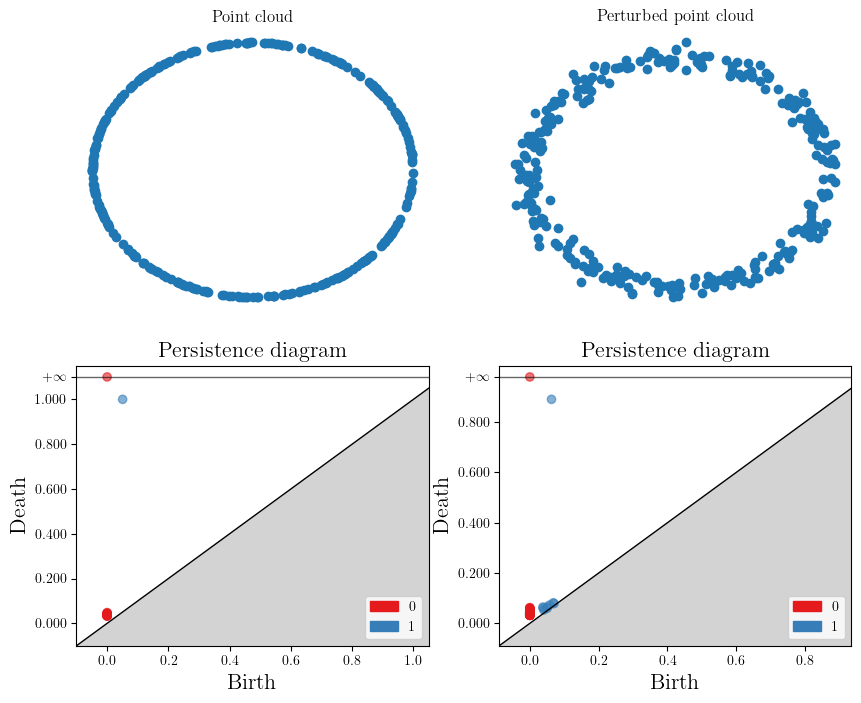

In [9]:
u.showcase_tda_stability()

That's it for the theoretical prerequisites!

## 2. A brief overview of computational foundations of TDA

While everything developed in the previous section perfectly makes sense from a theoretical perspective, a crucial question for the practitionner is 

> How do we compute the aforementioned intervals in practice?

For the sake of simplicity, we will focus on the case of the $\Cech$ filtration, though the idea developed in this section can be generalized. 

**Simplicial complexes:** A _simplicial complex_ is a combinatorial object that generalizes graphs. While graphs are made of vertices and edges (that are pairs of vertices), simplicial complexes allow for higher order interactions: given a set of vertices $V = \{v_1,\dots,v_m\}$, a simplicial complex $S$ on $V$ is formally a subset of $2^V$ such that if the $k$-_simplex_ $(v_{i_1}, \dots, v_{i_k})$ belongs to $S$, then all its _faces_ $(v_{i_1},\dots, \neg v_{i_j}, \dots, v_{i_k})$ should belong to $S$ as well (this notation meaning that the vertex $v_{i_j}$ has been removed). 

Concretely, a face $(a,b,c)$ can belong to a simplicial complex only if the edges $(a,b), (b,c), (c,a)$ already belong to the simpicial complex, just as an edge $(a,b)$ can belong to the complex (or to a graph) only if the vertices $a$ and $b$ belong to the complex as well. A simplex $\{v_{i_0},\dots,v_{i_k}\}$ is said to be of _dimension $k$_ (vertices are of dimension $0$, edges of dimension $1$, trangles of dimension $2$, and so on). The dimension of a complex is the highest dimension of its simplices. 

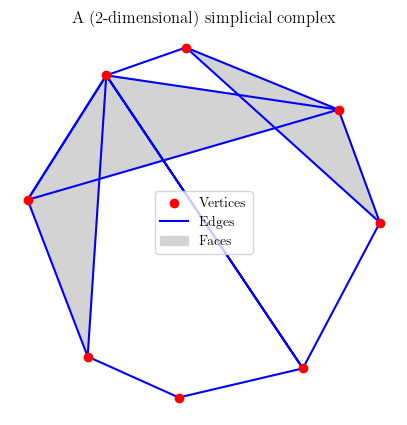

In [10]:
# Generate a 2 dimensional simplicial complex. As the vertices are located randomly, the result may not be very beautiful in some instances
# do not hesitate to run it several times.
u.showcase_simplicial_complex()

Because they are combinatorial objects, simplicial complexes can easily be encoded and represented on a computer using a _boundary matrix_. Namely, let $V = \{v_0,\dots,v_m\}$ denote a set of vertices, and $S \subset 2^V$ be a simplicial complex with $N = \# S$ simplices, labeled as $\sigma_1,\dots,\sigma_N$. Consider the $N \times N$ matrix $M$ defined as $M_{ij} = 1$ if $\sigma_j$ is a face of $\sigma_i$, $0$ otherwise. 

Note that the boundary of a vertex is $0$, and conversely, top-dimensional simplices in $S$ cannot be the boundary of something. 

For instance, $S = ( \{a\},\{b\},\{c\}, \{d\}, \{a,b\},\{a,c\},\{b,c\}, \{a,d\}, \{a,b,c\} )$ is a simplicial complex representing a (filled) triangle plus one additional edge, and its boundary matrix is given by

$$ \begin{pmatrix} 0 & 0 & 0 & 0 & 1 & 1 & 0 & 1 & 0 \\  0 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{pmatrix} $$

Naturally, this kind of matrices are often very sparse, and are thus represented as such to significantly improve the memory footprint and the running time of any further algorithm. 

**Filtration over simplicial complexes:** Let us now connect this notion of simplicial complexes to the ``theoretical'' notion of filtration introduced in the previous section. The idea is simple: given a simplicial complex $S$ and map $f : S \to \R$, we say that $f$ is a filtration over $S$ if $\forall \sigma \in S, \forall \sigma' \in \sigma,\ f(\sigma) > f(\sigma')$. 

In plain text, this means that the value $f$ assigns to a $k$-simplex should be higher than the value assigned to all its faces (and so on). From this, we obtained an _increasing sequence of simplicial complexes_ defined for $t \in \R$ as $S_t = \{ \sigma \in S,\ f(\sigma) \leq t\}$. 

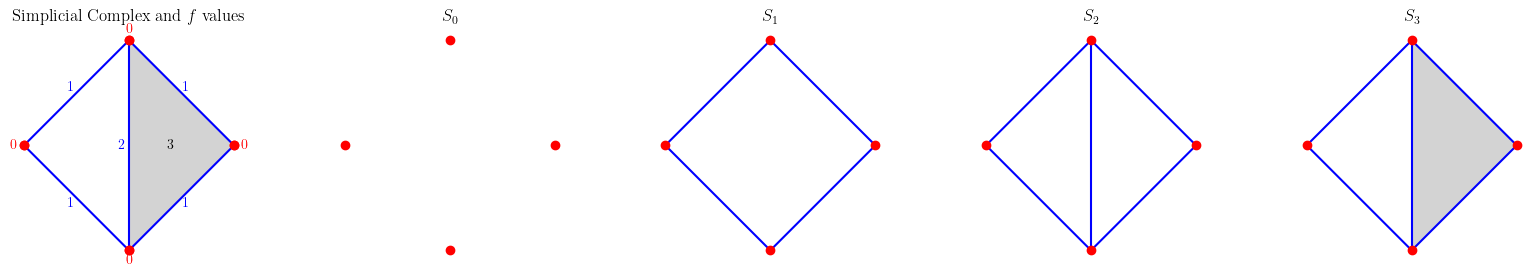

In [11]:
u.showcase_simplicial_filtration()

**$\Cech$ complexes:** There are many different ways to build simplicial filtrations over a given simplicial complex $S \subset 2^V$. For instance, if we are only given a map $f : V \to \R$ (the map only gives values on vertices), we may define a filtration $\hat{f}$ over $S$ as $\hat{f}(\sigma) = f(\sigma)$ if $\sigma$ is a vertex, and $\hat{f}(\sigma) = \max_{\sigma' \in \sigma} \hat{f}(\sigma')$ otherwise. That is, we _insert_ a simplex $\sigma$ when all its faces have been inserted. This filtration is called the _lower-star_ filtration. 

Now, let us talk about the $\Cech$ _simplicial_ filtration.

Consider a set of points $x_1,\dots,x_n \in \R^d$. Set $V = \{x_1,\dots,x_n\}$ and $S = 2^V$ be your complex (yes, we consider _all_ possible simplex in $S$). Now, define the filtration $f$ as 
$$f(\sigma) = \min \left\{ t,\ \bigcap_{x_i \in \sigma} B(x_i,t) \neq \emptyset \right\}$$
where $B(x_i, t)$ denote the (Euclidean) ball centered at $x_i$ of radius $t$. 

In plain text: a simplex $(x_{i_0},\dots,x_{i_k})$ is inserted at the first time/radius $t$ where all the balls of radius $t$ centered on the $x_{i_j}$ have a common intersection. Note in particular that $f(x_i) = 0$ for $i=1,\dots,n$, and $f(\{x_i, x_j\}) = \frac{1}{2} \|x_i - x_j\|$. 

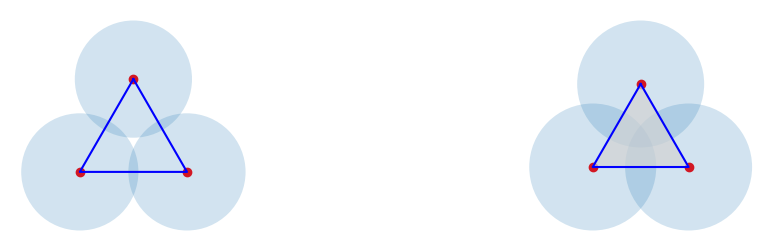

In [12]:
u.showcase_cech_simplicial_filtration()

A very nice result that legitimate this definition is the following, known as the _Nerve theorem_:

> Let $\XX = \R^d$, and $X = \{x_1,\dots,x_n\} \subset \R^d$ be a point cloud. Let $\FF_t$ be the sublevel set of the $\Cech$ filtration as defined in Section II.1 (the lightblue set in the previous figure), and $S_t$ be the (geometric realization of) the $\Cech$ simplicial complex as defined above. Then, the homology of $\FF_t$ and those of $S_t$ coincide. The same result holds for the persistence diagrams for $(\FF_t)_t$ and $(S_t)_t$. 

So basically, you can compute the topological features of the union of balls from the corresponding combinatorial object (that can be represented through a boundary matrix) with your computer :-) !

**Rips complex:** An issue with the $\Cech$ complex in practice is that checking whether $\bigcap_{x_i} B(x_i,t) \neq \emptyset$ becomes computationally expensive in high dimension. A workaround is to consider a slightly modified filtration, called the (Vietoris-)Rips filtration, where we set $f(\sigma) = 0$ if $\sigma$ is a vertex, and otherwise

$$f(\sigma) = \min \left\{t,\ \forall x_i, x_j \in \sigma,\ \frac{1}{2} \|x_i - x_j\| \leq t \right\}.$$

So namely, a simplex is inserted whenever all its vertices are at distance less than or equal to $t$. In particular, there cannot be "empty triangles" in Rips filtration: when three edges are forming a triangle, the corresponding face is immediatly inserted, instantly killing the newly formed loop. 

Checking whether a simplex $\sigma$ belongs to $S_t$ is much simpler than for the $\Cech$ simplicial filtration as it only depends on the pairwise distances between the points. Interestingly, this means that we can use the Rips filtration on much more sophisticated situations, where for instance we may consider other types of geometry than the Euclidean distance, such as the geodesic distance along a shape as done in [this paper](http://www.lix.polytechnique.fr/~maks/papers/perslocsig.pdf). 

Note: in some cases, the definition of the Rips filtration does not introduce the $\frac{1}{2}$; of course this does not change the concept (it may just rescale the birth time and death time of the topological features). 

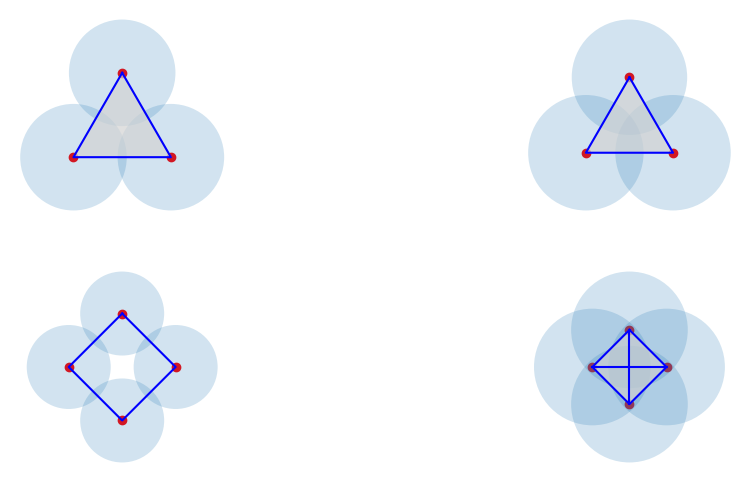

In [13]:
# A short illustration for the Rips filtration. The top-left Figure shows the difference with the Cech filtration: 
# even though the three balls does not intersect all together, the face (triangle) is introduced as they pairwise intersect.
u.showcase_rips_simplicial_filtration()

From an algorithmic perspective, the persistence diagram of a simplicial filtration (Rips, $\Cech$, lower-star, or any kind of filtration $(S_t)_t$ of a simplex $S$ induced by a function $f$) essentially boilds down to _reduce the boundary matrix_, where it is important to _order_ the simplices with respect to their filtration value, that is the column and the row of the matrix are corresponding to simplices $\sigma_1,\dots,\sigma_N$ (where $N = \# S$) are indexed such that $f(\sigma_1) \leq f(\sigma_2) \leq \dots \leq f(\sigma_N)$. Observe that this implies that the boundary matrix of $S$ is upper triangular. Furthermore, the reduction must be formed "from left to right". The matrix reduction will give you, for all topological feature, its birth and death time (filtration values at which the simplex creating/destroying the feature is introduced) and the corresponding simplices, called the _critical pair_ of the topological feature. For instance, a $1$-dimensional homological feature (loop) detected in the filtration will be represented by a pair $(\sigma_i,\sigma_j)$ where $\sigma_i$ must be an edge (the one creating the loop) and $\sigma_j$ a triangle (the one completely filling the loop), and the _persistence diagram_ (or _barcode_) will store the interval $(f(\sigma_i),f(\sigma_j))$ during which the feature persisted. 

We refer to [these lecture notes](https://courses.cs.duke.edu/fall06/cps296.1/Lectures/sec-VI-1.pdf) for details.

Note 1: While matrix reduction has a theoretical (worst-case) complexity of order $\mathcal{O}(N^3)$, the sparsity of the matrix makes the algorithm typically run in $\mathcal{O}(N)$. Beware that $N$ is the number of simplex in your complex, so this can be quite high!

Note 2: Homology groups of dimension $d$ (e.g. $d=1$, loops) only depend on simplices of dimension up to $d+1$ (e.g. triangles). If you are only interested in low dimensional homology groups, you should simply ignore higher dimensional simplices, that will save you a lot of running time!

Note 3: In practice, the boundary matrix is considered to have coefficients in the field $\frac{\Z}{p\Z}$ for $p$ prime (this is a byproduct of how you define homology groups). However, the choice of $p$ seems to have a limited impact according to [this paper](https://link.springer.com/article/10.1007/s00454-023-00544-7). 

**Summary:** 
- Simplicial complexes are combinatorial object that can be thought as generalisation of graphs.
- They can be used to represent geometric objects embedded in $\R^d$.
- There exists a natural notion of filtration for simplicial complexes.
- The $\Cech$ filtration of topological spaces admits a combinatorial counterpart in the context of simplicial complexes. These two notions coincide in terms of homology groups.
- The $\Cech$ simplicial filtration being quite hard to compute, it is often replaced by the Rips filtration.
- In any case, given $S$ and $f$, computing the persistence diagram of the increasing sequence of simplicial complexes $(S_t)_t$ boils down to perform a matrix reduction algorithm. 

## 3. Persistent Homology for time series and dynamical systems

We have spend a significant amount of time explaining how to extract topological information from point clouds, using the $\Cech$ or the (Vietoris-)Rips filtration. What about times series and dynamical systems?

Here, we will consider a function $s : \R \to \R^d$ that we access through a finite sample $s_t,\ t = 0,1, \dots, T$, typically $s_t = s(t * \omega)$ for some $\omega > 0$. 

First, let us stress that there could be many different ways to apply TDA and persistent homology to dynamical systems, as long as you find a way to build a filtration from your observations $(s_t)_{t=1,\dots,T}$. We present here a common approach use in TDA that leverages the previous notions we've introduced: the _sliding window_ or _time delay embedding_ (tde).

Say for simplicity that $s_t \in \R$ (1D signal). The $k$-tde of $(s_t)_t$ is the $k$-dimensional point cloud with $n = T - 2(k-1)$ points where $x_i = (s_i, s_{i+1}, \dots, s_{i+k})$.

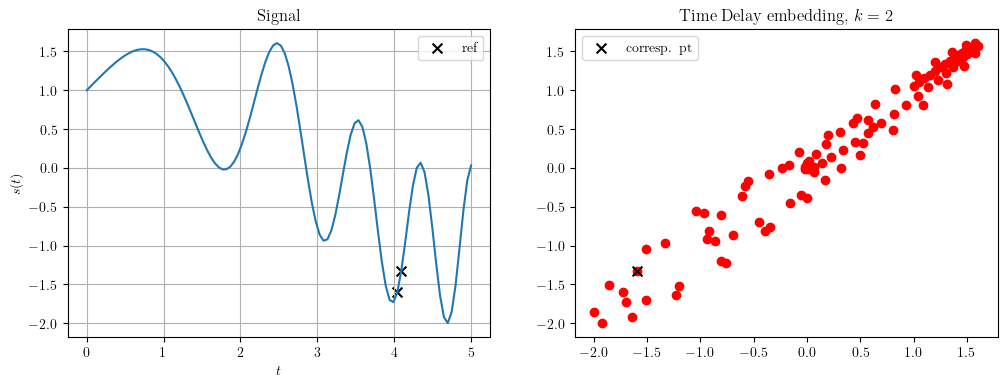

In [14]:
u.showcase_time_delay_embedding()

What motivates this approach is the following idea: if there is some underlying periodicity in $s$ _up to a time-reparametrisation_. Namely, $s(t) = f(\varphi(t))$ with $f$ periodic and $\varphi$ increasing; for instance $t \mapsto \sin(e^t)$. Intuitively, (even local) periodicity is translated as cycles in the sliding window embedding; cycles that can be detected as $1$-dimensional topological features in the corresponding persistence diagram! 
You can look [this paper](https://arxiv.org/pdf/2205.14390.pdf) to learn more if you are interested. 

And quite interestingly as well, a small noise in the recordings $s_t$ will be reflected as a small perturbation of the points in the sliding window embedding, hence 

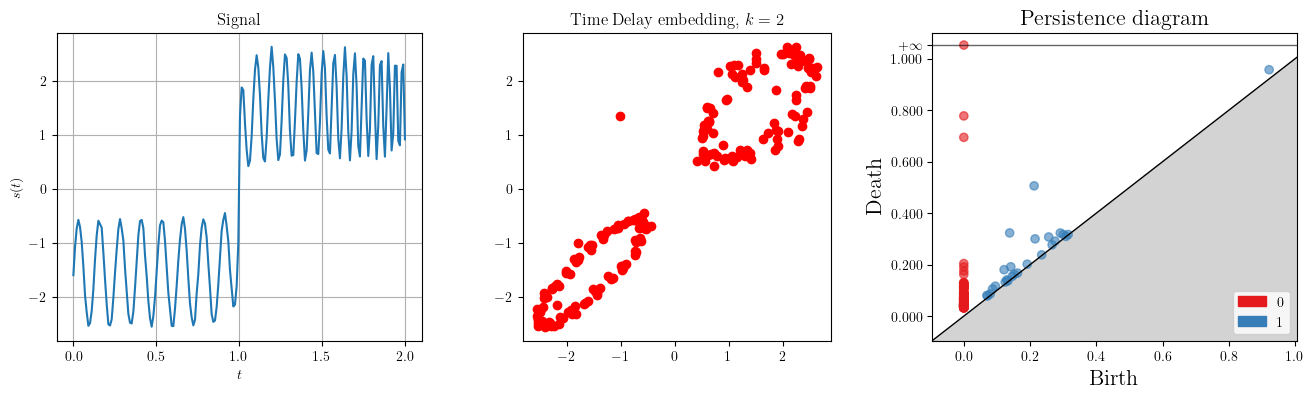

In [15]:
u.showcase_sw_periodicity(noise_level=1.)

The figure above attempts to summarize these ideas: we plot a signal $s : \R \to \R$ that is somewhat ("locally") periodic in $[0,1]$, while it is (locally) periodic up to a reparametrization in $[1,2]$, and overall we added a (small) Gaussian noise (so that it is actually only "almost" periodic on the two intervals). 

The tde exibits two cycles that are reflected in the persistence diagram on the right (unless you have been quite unlucky with the random `noise_level`, in which case you can set it to `0.`. You can try increasing it, and see that it becomes harder to detect the cycles). 

## 4. Vectorization of topological descriptors

Persistence diagrams (PDs) are interesting in themselves as quantitative interpretable topological descriptors. However, incorporating them in downstream tasks is not trivial for one major reason: the space of persistence diagrams $\mathcal{D}$ is not a finite-dimensional vector space, a prerequisite of many machine learning algorithms (think of linear regressions, $k$-means, etc.). 

A simple yet useful workaround is simply to _vectorize_ diagrams, that is designing a map $\varphi$ that takes a diagram as input and returns a vector in $\R^d$. 
Of course, the vectorization should preserve as much as possible the intrinsic geometry of persistence diagrams, that is we expect that 
$$W(\mu,\nu) \simeq \|\varphi(\mu) - \varphi(\nu)\|_2$$
for two persistence diagrams $\mu,\nu$, compared using the Wasserstein distance between persistence diagrams $W$ (see Section II.1). Having a perfect isometry is known to be hopeless, but one can still have Lipschitz relations (with some limitations on the Lipschitz constant). Among popular vectorization, we may mention 
- [Persistence images](https://www.jmlr.org/papers/volume18/16-337/16-337.pdf), which (roughly speaking) put a Gaussian distribution on each point in the diagram weighted with respect to its distance to the diagonal, then discretizing it using a grid (hence turning a diagram into an image). 
- [Persistence landscapes and silhouette](https://www.jmlr.org/papers/volume16/bubenik15a/bubenik15a.pdf), which (roughly speaking as well) put a triangle function on each point in the diagram and then take a sort of average (for the silhouette).

Note that a similar approach is provided by Kernel methods, we refer the interested reader to [this paper](http://proceedings.mlr.press/v70/carriere17a/carriere17a.pdf) for further information. 

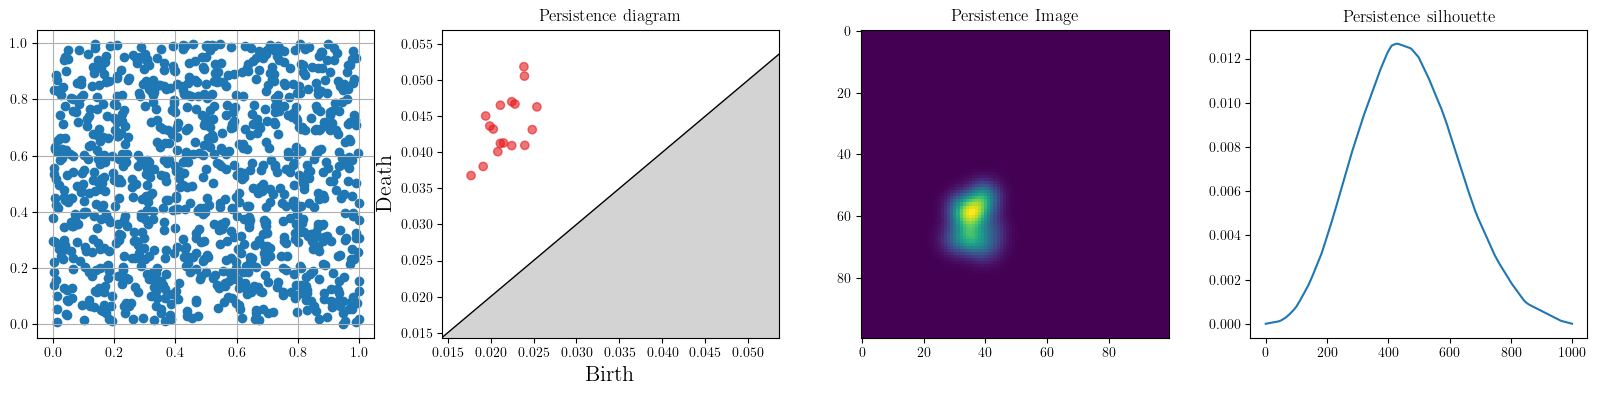

In [16]:
u.showcase_vectorization()

## 5. Topological Optimization

Last but not least: it is now more and more common to consider using topological descriptors such as persistence diagrams in _optimization_ task, in order to incorporate topological priors in your modelisation problem. 

For instance, you may be trying to model some 3D dynamical system that depends on a parameter $\theta$, let's denote $(s_{\theta,t})_{t}$ the (discrete) observations you can generate with your model. 
Now, assume that you know that the trajectories of your flow should be nearly circular. 
Then, a natural thing you can try is to optimize $\theta$ so that the (Cech or Rips) persistence diagram of the observations $(s_{\theta,t})_{t=1}^T$ (for $T$ large), in homology dimension $1$, has a single prominent (far from the diagonal) point. Therefore, given a current $\theta$, we want to modify it so that $(s_{\theta,t})_{t=1}^T$ changes so that its diagram satisfies some property as much as possible. 

More generally, the question of _topological optimization_ reads like this: given a point cloud $X(\theta) \subset \R^d$ parametrized by a parameter $\theta \in \Theta \subset \R^p$ and a _loss function_ $L : \mathcal{D} \to \R$ (where we recall that $\mathcal{D}$ denote the space of persistence diagrams), how to minimize

$$ F : \theta \mapsto L(\dgm(X(\theta)))\ ,$$

where $\dgm$ denote the Rips (or $\Cech$, but Rips is simpler) diagram of the point cloud $X(\theta)$. 

Formally speaking, $F$ goes from $\R^d \to \R$ and, under mild assumptions, is Lipschitz hence [admits a gradient almost everywhere](https://en.wikipedia.org/wiki/Rademacher%27s_theorem). 
Therefore, it should be possible to minmize it using a standard [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm. 
However, how does one compute $\nabla F(\theta)$ ?

This is by no mean a trivial question, because we cannot apply the chain rule faithfully: the intermediate space $\mathcal{D}$ is not a vector space (see the previous section), so defining for instance $\nabla L(\mu)$ at some $\mu \in \mathcal{D}$ is unclear (this can be done by relying on [Alexandrov geometry](https://arxiv.org/pdf/1903.08539.pdf) but this is a story for another time). 

Nonetheless, our intuition tells us the following: $\mu \mapsto L(\mu)$ depends on the points $(b_i, d_i)_i$ in the diagram, so trying to locally decrease $L$ should boil down to moving the points in $\mu$ in some prescribed directions. Now, recall that the points of $\mu$ themselves depends on the _filtration values_ of the Rips filtration, which itself only depends on the _distances_ between pairs of points in $X(\theta)$, themselves naturally depending on the points coordinates, which in turn depends on $\theta$. 
Hopefully, we should be able to backpropagate these dependancies, to eventually get the gradient of $L$ with respect to $\theta$. 
A key contribution of [this work](https://link.springer.com/article/10.1007/s10208-021-09522-y) is to properly justify that _yes_, composing the gradient of all these elementary operation indeed yields a gradient for $\theta \mapsto L(\theta)$. 

Topological optimization is a fairly recent research topic in TDA, with only few code available (but some in `Gudhi`, see the next section!) and a lot of progress remains to be done. 
Applying it in the context of dynamical systems has never been done and convincing experiments would be highly relevant contributions to the field. 

---

# III. Gudhi

## 1. Overall presentation of Gudhi

First and foremost, the (`Python`) documentation for `Gudhi` is available [here](https://gudhi.inria.fr/python/latest/). 
This should be your main reference when trying to use the library. 

`Gudhi` is a fairly sophisiticated library, and it may not be obvious to navigate through the different interfaces, constructors, etc. 
It gives you a tight control on every object you manipulate, which can be very useful if you want to experiment new ideas. 
On the other hand, you may sometime feel a bit overloaded with all the possible options. 
The goal of this Section is to facilitate this task by providing a biased presentation of the library toward the tools we will probably need. 
You are more than encouraged to investigate other options provided by the library.

With `Gudhi` you can (not extensive):
- Create and manipulate combinatorial structures (representing simplicial complexes and filtrations of them) optimized for downstream computation of persistent homology. There are different structures available, we will focus on the `SimplexTree` structure here. 
- Extract topological information (persistence diagrams) from these objects.
- Manipulating persistence diagrams: compare them with the corresponding metrics, vectorize them (see Section II.4), etc.
- Do all these steps in an (automatic!) differentiable way relying on `tensorflow`. That is you can eventually have access to gradients (that you do not have to compute by yourself!) and you will be able to minimize objective function that depends on the parameters of your problem (e.g. the coordinates of the points in your input point cloud). 

Note: normally, you should have run the first (code) cell of the notebook without error, hence you have access to `Gudhi` with the shortcut `gd`. 

**Dependencies:** Some modules in `Gudhi` have some dependencies that are not installed by default (so that a user not interested in those do not have to install them). For instance, the [persistence representations module](https://gudhi.inria.fr/python/latest/#persistence-representations) (or at least some methods therein) depends on [scikit-learn](https://scikit-learn.org/stable/) and possibly [tensorflow](https://www.tensorflow.org/?hl=fr). Therefore, don't be surprised if at some point you try to use a function and get an error message like `no module named XXX` when calling a genuine `Gudhi` function. Check the dependencies first and install the corresponding packages!

## 2. The SimplexTree interface

The `SimplexTree` structure is a way to efficiently store simplicial complexes along with filtration values. 
<!-- Everything is done so that the axioms of filtered simplicial complexes (see Section II.2) are preserved during the contruction. -->

The first step is to instanciate a `SimplexTree`. After running the following cell, you will essentially have built an empty simplicial complex. 

In [17]:
st = gd.SimplexTree()

We can insert simplices in it. Let us start with a vertex, labeled as `[0]` (simplices are always represented as `list` of `int` in this API). 

Note: this method returns a Boolean, saying if the vertex is new (returns `True`) or if it was already there in the `SimplexTree` (returns `False`). So if you run the cell twice, it should return `True` the first time, and `False` the second time. 

In [18]:
st.insert([0])

True

Let us check what is inside my `SimplexTree`. 
For this, we call `.get_filtration()`, which returns a generator (something we can iterate on) made of pairs `(simplex, value)`. 
As you will see, the default filtration value of a simplex when calling `.insert` is `0.`. 

In [19]:
for simplex, value in st.get_filtration():
    print("Simplex:", simplex, "---> value:", value)

Simplex: [0] ---> value: 0.0


Let us introduce another simplex. An edge this time, and for which we specify that the filtration value is `2.0`. 

In [20]:
st.insert([0,1], filtration=2.0)

True

A warning should raise in your mind: here we inserted the edge `[0,1]` **before** inserting the vertex `[1]`. 
How does `Gudhi` behaves in that case?

In [21]:
for simplex, value in st.get_filtration():
    print("Simplex:", simplex, "---> value:", value)

Simplex: [0] ---> value: 0.0
Simplex: [1] ---> value: 2.0
Simplex: [0, 1] ---> value: 2.0


Nice: when introducing an edge, it automatically introduce the missing vertex. Furthermore, it assigns the chosen filtration value of the edge to the newly added vertices. Of course, this works with higher dimensional simplices (all the missing faces are added with the same filtration value, and so on).

In [22]:
st.insert([0, 1, 2], filtration=3.0)
for simplex, value in st.get_filtration():
    print("Simplex:", simplex, "---> value:", value)

Simplex: [0] ---> value: 0.0
Simplex: [1] ---> value: 2.0
Simplex: [0, 1] ---> value: 2.0
Simplex: [2] ---> value: 3.0
Simplex: [0, 2] ---> value: 3.0
Simplex: [1, 2] ---> value: 3.0
Simplex: [0, 1, 2] ---> value: 3.0


Let us manipulate a bit more our `SimplexTree` to showcase some behavior. 

In [23]:
st.insert([4], filtration = 5.0)  # add a new vertex with filtration value 5.0
st.insert([3,4], filtration = 3.0) # add a new edge between vertex 3 and 4 with filtration value 3.0

st.insert([0, 1, 2], filtration=3.0)
for simplex, value in st.get_filtration():
    print("Simplex:", simplex, "---> value:", value)

Simplex: [0] ---> value: 0.0
Simplex: [1] ---> value: 2.0
Simplex: [0, 1] ---> value: 2.0
Simplex: [2] ---> value: 3.0
Simplex: [0, 2] ---> value: 3.0
Simplex: [1, 2] ---> value: 3.0
Simplex: [0, 1, 2] ---> value: 3.0
Simplex: [3] ---> value: 3.0
Simplex: [4] ---> value: 3.0
Simplex: [3, 4] ---> value: 3.0


**<span style="color:blue">Question:</span>** What happened there? What motivates this behavior?

All of this is neat, but of course we do not want to create sophisticated simplicial complexes (like the $\Cech$ or the Rips) by hand. 
Naturally, these are implemented in `Gudhi`. 
It is done in two steps (but one line): we instanciate a `RipsComplex` object on a given point cloud `X`, and then turn it into a `SimplexTree` using the method `.create_simplex_tree()`. You must specify the maximal dimension of simplices you want to consider in your `SimplexTree` (e.g. `max_dimension=2` will include vertices, faces and triangles, but nothing above). 

Note: If you want to compute topological features of dimension $k$, you need to consider simplices of dimension up to $k+1$. If you are interested in loops for instance, you should set `max_dimension=2` (setting a higher value would work, but would make your simplicial complex much larger, hence increase the memory footprint and running times). 

Simplex: [0] ---> value: 0.0
Simplex: [1] ---> value: 0.0
Simplex: [2] ---> value: 0.0
Simplex: [3] ---> value: 0.0
Simplex: [4] ---> value: 0.0
Simplex: [5] ---> value: 0.0
Simplex: [6] ---> value: 0.0
Simplex: [7] ---> value: 0.0
Simplex: [0, 1] ---> value: 1.0
Simplex: [1, 2] ---> value: 1.0
Simplex: [2, 3] ---> value: 1.0
Simplex: [3, 4] ---> value: 1.0
Simplex: [4, 5] ---> value: 1.0
Simplex: [5, 6] ---> value: 1.0
Simplex: [0, 7] ---> value: 1.0
Simplex: [6, 7] ---> value: 1.0
Simplex: [1, 3] ---> value: 1.4142135623730951
Simplex: [1, 2, 3] ---> value: 1.4142135623730951
Simplex: [3, 5] ---> value: 1.4142135623730951
Simplex: [3, 4, 5] ---> value: 1.4142135623730951
Simplex: [1, 7] ---> value: 1.4142135623730951
Simplex: [0, 1, 7] ---> value: 1.4142135623730951
Simplex: [5, 7] ---> value: 1.4142135623730951
Simplex: [5, 6, 7] ---> value: 1.4142135623730951
Simplex: [0, 2] ---> value: 2.0
Simplex: [0, 1, 2] ---> value: 2.0
Simplex: [2, 4] ---> value: 2.0
Simplex: [2, 3, 4] ---> v

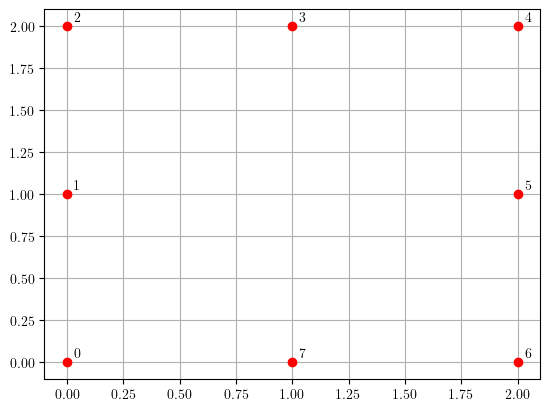

In [24]:
X = np.array([[0,0], [0,1], [0,2], [1,2], [2,2], [2,1], [2,0], [1,0]])   # a 2-dimensional point cloud
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], color='red', zorder=5)
for i, x in enumerate(X):
    ax.annotate('%s' %i, x + (0.03, 0.03))
ax.grid()

rips_complex = gd.RipsComplex(points=X).create_simplex_tree(max_dimension=2)

for simplex, value in rips_complex.get_filtration():
    print("Simplex:", simplex, "---> value:", value)

Recall that the Rips filtration only depends on the _pairwise distances_ between the points in your point cloud. 
In particular you can define it for points that would only belong to a metric space $\XX$ that may not be the Euclidean space (e.g. a manifold equipped with its geodesic distance, shortest path on a graph, etc). For this, the only think you have to do is to specify `distance_matrix = M` instead of `points=X` when calling `RipsComplex()`. 

Note that, formally speaking, `M` does not even need to be a proper distance matrix. It can be any square matrix with non-negative entries. 

In [25]:
M = np.random.rand(4, 4)  # A random 4x4 square matrix with entries in (0,1)

rips_complex = gd.RipsComplex(distance_matrix=M).create_simplex_tree(max_dimension=2)

for simplex, value in rips_complex.get_filtration():
    print("Simplex:", simplex, "---> value:", value)

Simplex: [0] ---> value: 0.0
Simplex: [1] ---> value: 0.0
Simplex: [2] ---> value: 0.0
Simplex: [3] ---> value: 0.0
Simplex: [1, 3] ---> value: 0.12628582984808145
Simplex: [2, 3] ---> value: 0.14834324394652643
Simplex: [1, 2] ---> value: 0.3228545589508307
Simplex: [1, 2, 3] ---> value: 0.3228545589508307
Simplex: [0, 2] ---> value: 0.3615988007382981
Simplex: [0, 3] ---> value: 0.415702267407685
Simplex: [0, 2, 3] ---> value: 0.415702267407685
Simplex: [0, 1] ---> value: 0.4678051145898179
Simplex: [0, 1, 2] ---> value: 0.4678051145898179
Simplex: [0, 1, 3] ---> value: 0.4678051145898179


**Some additional remarks:** 
- You can also introduce a parameter `max_edge_length` in `RipsComplex()` that stop the insertion of edges (and further triangles, etc.) above a given threshold (theoretically, this is equivalent to set the filtration value at $+\infty$). This can be convenient if you know that you only need to look at things ''locally'' and can significantly reduce the size of your complex (hence improve computational efficiency).
- An equivalent construction to build the $\Cech$ simplicial filtration can be done using the Class `AlphaComplex()` followed by `.create_simplex_tree()` as well. Beware that, for some technical reasons, the filtration values will be _squared_ distances, so if you really want to get the $\Cech$ filtration, you need to take the square root of the filtration values provided by your `AlphaComplex`. 

## 3. Extracting and manipulating persistence diagrams

Now that we can construct simplicial complex along with filtration values, we should be able to compute persistent homology. The pipeline is simple: consider your `SimplexTree` (should it be a `RipsComplex`, an `AlphaComplex` or something else you designed) and call the method `.compute_persistence()`. This method returns `None` (nothing), but it makes accessible all the important topological information you may want, basically using the method `.persistence_intervals_in_dimension(dimension=...)` to get the list of intervals (that is, the persistence diagram of barcode) accounting for a specific homology dimension (e.g. setting `dimension=1` will return the list of intervals account for birth and deaths of loops in your filtration). 

Beware: if you call functions like `persistence_intervals_in_dimension()` before running `compute_persistence()`, you will get an error. 

Note: Instead of `compute_persistence()`, you can equivalently run `persistence()`, which will both compute the persistence and return persistence intervals in all dimensions (that is, the whole persistence diagram). 

Note: Diagram can easily be visualized using `plot_persistence_diagram(dgm, axes=ax)`, where `dgm` is a persistence diagram (obtained either by calling `persistence(), persistence_intervals_in_dimension()` or simply passing a `(n x 2) np.array`, and `ax` is a matplotlib `Axes`. You similarly have access to `plot_persistence_barcode()`. Note that this plot functions _returns the `ax`_, so you can modiify the plot afterward. 


Text(0.5, 1.0, 'PD (you can modify the title)')

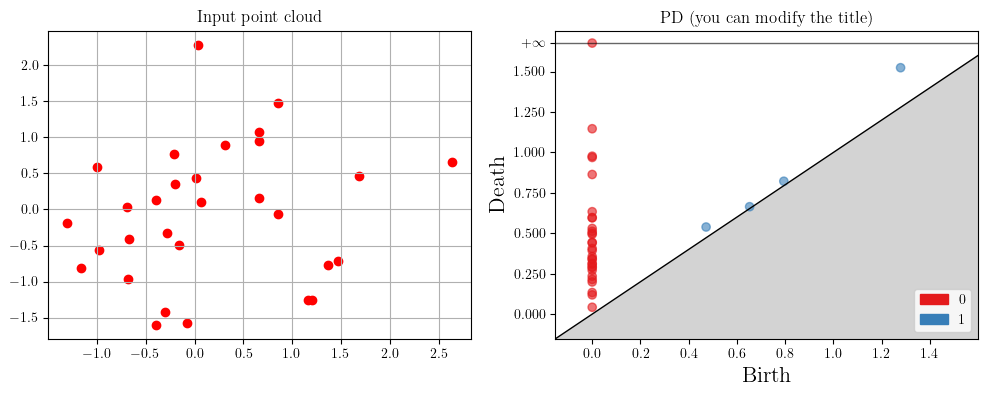

In [26]:
# Let us give an example with a Rips Filtration on a random point cloud in 2D. 

# Built the point cloud
X = np.random.randn(30, 2)  # 30 points in dimension 2
# Built the Rips Simplicial Complex
rc = gd.RipsComplex(points=X).create_simplex_tree(max_dimension=2)  # A RipsComplex where we introduce vertices, edges and triangles, but not higher dimensional simplices.
# Compute and reads its persistence (in any dimension)
dgm = rc.persistence()  # We compute its persistence diagram

# Plot all of this.
fig, axs = plt.subplots(1, 2, figsize=(12,4))
ax = axs[0]
ax.scatter(X[:,0], X[:,1], color='red')
ax.set_title("Input point cloud")
ax.grid()

ax = axs[1]
ax = gd.plot_persistence_diagram(dgm, axes=ax)
ax.set_title("PD (you can modify the title)")

You can also compute the distance between persistence diagrams _in a single homological dimension (a priori, the same)_. Two kind of metrics are available in `Gudhi`: the [Wasserstein](https://gudhi.inria.fr/python/latest/#wasserstein-distance) and the [Bottleneck](https://gudhi.inria.fr/python/latest/#bottleneck-distance) distance (which are very similar to each other). 

They are available in two ways: either in the module `gudhi.wasserstein` or in `gudhi.representations.metrics`. 
The second module is quite useful as it mimics the `fit` and `transform` API of `scikit-learn`, so we will showcase it. 
It means that the distance between two diagrams is computed by first instanciating an object `W = gudhi.representation.metrics.WassersteinDistance(*args)`. 
It can also be directly used to compute the pairwise distance matrix for a given set of diagrams (useful in many situations in statistics and learning).

Note: the Wasserstein distance depends on a parameter $p$ encoded as `order` in this API---other parameters are also involved (like the method used for computation), see [the documentation](https://gudhi.inria.fr/python/latest/representations.html#gudhi.representations.metrics.WassersteinDistance) for details.

In [27]:
# We generate three random 2D point clouds
X1 = np.random.randn(20, 2)
X2 = np.random.randn(30, 2)
X3 = np.random.randn(50, 2)

# Compute their Rips filtrations
rc1 = gd.RipsComplex(points=X1).create_simplex_tree(max_dimension=2)
rc2 = gd.RipsComplex(points=X2).create_simplex_tree(max_dimension=2)
rc3 = gd.RipsComplex(points=X3).create_simplex_tree(max_dimension=2)

# Compute their persistence
rc1.compute_persistence()
rc2.compute_persistence()
rc3.compute_persistence()

# Get the diagram in dimension 1 (loops)
dgm1 = rc1.persistence_intervals_in_dimension(1)
dgm2 = rc2.persistence_intervals_in_dimension(1)
dgm3 = rc3.persistence_intervals_in_dimension(1)

# Now compute the Wasserstein Distance between the first two diagrams:
Wdist = gd.representations.metrics.WassersteinDistance(order=2.)
dist = Wdist(dgm1, dgm2)

print("Distance between the two diagrams: %.3f" %dist)

# and now the pairwise distances matrix using a sklearn-like API
dgm_set = [dgm1, dgm2, dgm3]
Wdist.fit(dgm_set)
dist_matrix = Wdist.transform(dgm_set)  # Note: we could use another set of diagrams to compute pairwise distance between the first set uesd in fit, and another second set of diagrams.

print("\nPairwise distance matrix between the three diagrams:")
print(np.round(dist_matrix, 3))

Distance between the two diagrams: 0.078

Pairwise distance matrix between the three diagrams:
[[0.    0.078 0.085]
 [0.078 0.    0.083]
 [0.085 0.083 0.   ]]


Eventually, you can use vectorization tools from the module `gudhi.representations.vector_methods`, we showcase here how to use the Persistence Image vectorization and refer to [the documentation](https://gudhi.inria.fr/python/latest/representations.html#module-gudhi.representations.vector_methods) for the various possibilities available.

Here as well, you start by instanciating an object from the class `gudhi.representation.vertor_methods.PersistenceImage(*args)` with a set of `*args` to be specified. Recall (see Section II.4) that Persistence Images mostly boils down to put a weighted Gaussian kernel on each point of the diagrams, and then discretizing the resulting density on a grid of prescribed resolution. 

We will thus specify (other options are available, see [the documentation](https://gudhi.inria.fr/python/latest/representations.html#gudhi.representations.vector_methods.PersistenceImage) as always)
- the `bandwidth` of the Gaussian kernels,
- the `resolution` (final image size)

Note: in order to be immediatly incorporated in machine learning pipelines, the output of `PersistenceImage.transform(*args)` are (1D) vectors, that is if you chose a resolution of `30x30`, you will have vectors of size `900`. If you want to plot the persistence images as matrices (using `imshow` in matplotlib), you must `reshape` them first.

Note: if you want to use these methods for a _single_ diagram `dgm`, the easiest way to go is to call them with the list `[dgm]`. 

In [28]:
# We use the same diagram list as above, so do not forget to run the previous cell first.
# Instanciate the object
reso = 30, 30
PI = gd.representations.vector_methods.PersistenceImage(bandwidth=0.05, resolution=reso)
# fit it to the dataset (so that it adapts few internal parameters)
PI.fit(dgm_set)
# And now we compute the persistence images of all diagrams in our list.
final_persistence_images = PI.transform(dgm_set)

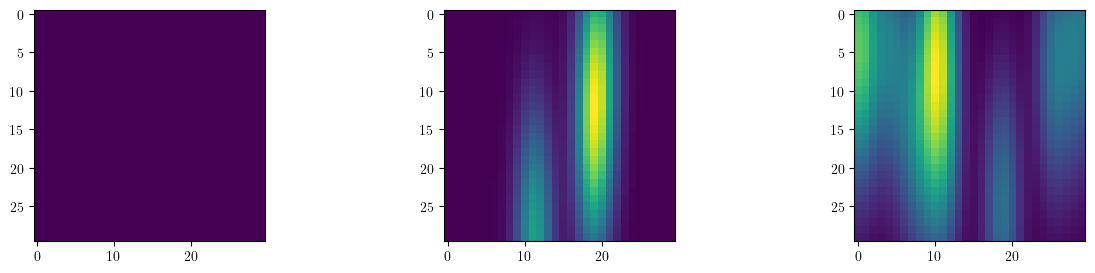

In [29]:
n = len(dgm_set)
fig, axs = plt.subplots(1, n, figsize=(15,3))
for pim, ax in zip(final_persistence_images, axs):
    ax.imshow(pim.reshape(reso))

## 4. Topological Optimization with Gudhi

Eventually, let us showcase how to perform topological optimization with Gudhi. 
This is based on [this tutorial](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-optimization.ipynb) (by [Mathieu Carrière](https://mathieucarriere.github.io/website/)). 

Topological optimization with `Gudhi` is performed by manipulating `tensorflow` objects. The `tensorflow` API may be scary at first sight, but enables powerful (and eventually rather seamless) optimization tools in general; in particular everything can be plugged with neural networks using `keras`, etc. 

Note: of course you must have `tensorflow` installed to run this section. 

The goal of this experiment is to take a point cloud and _maximize_ the _total persistence_ of its Rips diagram (in homology dimension $1$), that is we want to minimize
$$ L : X \mapsto - \sum_{(b_i, d_i) \in \dgm(X)} \frac{1}{p} |d_i - b_i|^p, $$
for some $p \geq 1$, or in plain text: the sum of the length of all intervals in its diagram. 
Minimizing this loss will essentially move the points in $X$ in order to favor the apparition of (big) loops.

Note that minimizing this loss will simply makes the term $|d_i - b_i|^p \to \infty$. 
To make the problem a bit more interesting, we add a regularization term to confine the points of $X$ that would go outside $[-1,1]^2$, so the loss eventually reads

$$L'(X) = L(X) + \sum_{x_i \in X} \mathrm{dist}(x_i, [-1,1]^2).$$

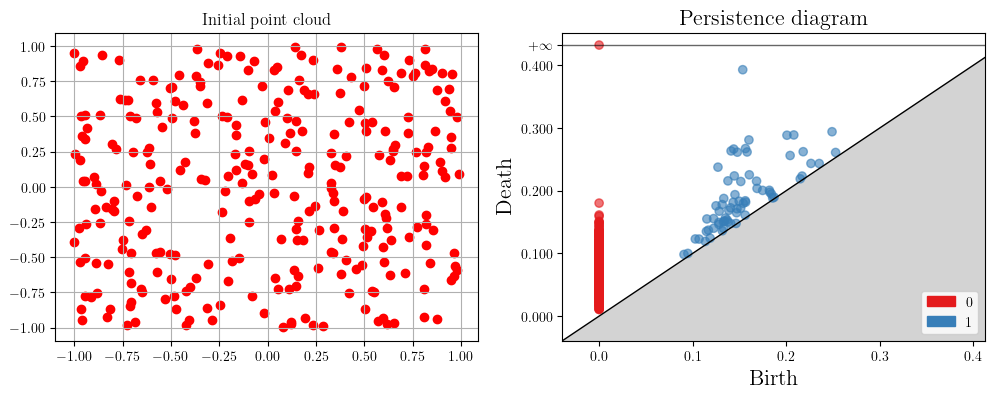

In [30]:
# Generate and visualize the point cloud, along with its persistence diagrams
np.random.seed(1)
Xinit = np.array(np.random.uniform(high=1., low=-1., size=(300,2)), dtype=np.float32)
st = gd.RipsComplex(points=Xinit, max_edge_length=1.).create_simplex_tree(max_dimension=2)
dgm = st.persistence()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
ax.scatter(Xinit[:,0], Xinit[:,1], color='red')
ax.set_title("Initial point cloud")
ax.grid()
ax = axs[1]
plot = gd.plot_persistence_diagram(dgm, axes=ax)

We want to minimize the loss function $X \mapsto L(X)$  (note the $-$ sign in front of the loss). 
For this, we must state that $X$ is a `tensorflow` `Variable`, initialized at `Xinit`. 
Saying that `X` is `trainable` means that it will be optimized on when trying to minimize $L$. 

In [31]:
X = tf.Variable(initial_value=Xinit, trainable=True)

Now, we will instanciate a `RipsLayer`, which is a `tensorflow`-compatible way to compute a persistence diagram. It means that when applying a `RipsLayer` to a `tf.Variable` will compute its Vietoris-Rips persistence diagram _in a differentiable way_; i.e. we will have access to gradients!

In [32]:
layer = gd.tensorflow.RipsLayer(maximum_edge_length=1., homology_dimensions=[1])

Now we instanciate some parameters that are useful for the training in tensorflow (parameters of the gradient descent):

In [33]:
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.)

And now we perform our gradient descent!

In [34]:
losses, dgms = [], []
for epoch in tqdm(range(200+1)):
    
    with tf.GradientTape() as tape:  # tensorflow syntax
        # We compute the diagram of the current X
        dgm = layer.call(X)[0][0]  
        # We compute the loss at X
        persistence_loss = -tf.math.reduce_sum(tf.square(.5*(dgm[:,1]-dgm[:,0])))
        # Unit square regularization
        regularization = tf.reduce_sum(tf.maximum(tf.abs(X)-1, 0))
        # Compute the loss
        loss = persistence_loss + regularization

    # Now, we ask tensorflow "compute the gradient of the loss with respect to the (single) variable X"
    gradients = tape.gradient(loss, [X])
    
    # We also apply a small random noise to the gradient to ensure convergence 
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [X]))
    losses.append(loss.numpy())
    dgms.append(dgm)

100%|██████████| 201/201 [01:16<00:00,  2.64it/s]


We can now visualize the resulting point cloud, resulting diagram, and evolution of the loss during the gradient descent!

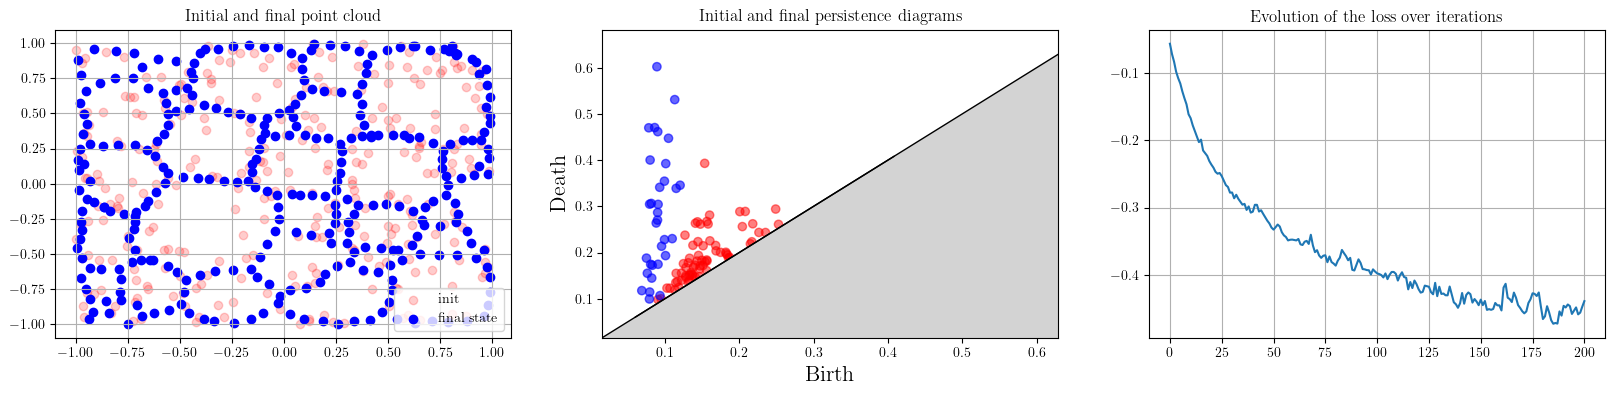

In [35]:
Xnp = X.numpy()  # turns X back to a numpy variable for plotting purpose

fig, axs = plt.subplots(1, 3, figsize=(20,4))

ax = axs[0]
ax.scatter(Xinit[:,0], Xinit[:,1], color='red', label='init', alpha=0.2)
ax.scatter(Xnp[:,0], Xnp[:,1], color='blue', label='final state')
ax.legend()
ax.grid()
ax.set_title("Initial and final point cloud")

ax = axs[1]
gd.plot_persistence_diagram(dgms[0].numpy(), axes=ax, colormap=[[1,0,0]], alpha=0.5)
gd.plot_persistence_diagram(dgms[-1].numpy(), axes=ax, colormap=[[0,0,1]])
ax.set_title("Initial and final persistence diagrams")

ax = axs[2]
ax.plot(losses)
ax.set_title("Evolution of the loss over iterations")
ax.grid()

## 5. Contributing to Gudhi

If you want to contribute to Gudhi, you should look at [this page](https://github.com/GUDHI/gudhi-devel/blob/master/.github/CONTRIBUTING.md) and [that one](https://github.com/GUDHI/gudhi-devel/blob/master/.github/how_to_use_github_to_contribute_to_gudhi.md). 

---

# IV. Your turn: experiment TDA on Time Series

## 1. The Orbit Dataset

The _Orbit dataset_ is a common toy dataset used in TDA to benchmark experiments. Each observation in this dataset is the output of a  2D discrete dynamical system in $[0,1]^2$ described by the equations

$$x_{n+1}=x_n+ry_n(1-y_n) \qquad \text{(mod 1)}$$
$$y_{n+1}=y_n+rx_{n+1}(1-x_{n+1}) \qquad \text{(mod 1)}$$

where $r$ is a parameter. Depending on the value of $r$, orbits can have quite varying trajectories, with quite different topologies!

You can sample trajectories using the function `u.generate_orbit(num_pts, r)` in `utils.py`.

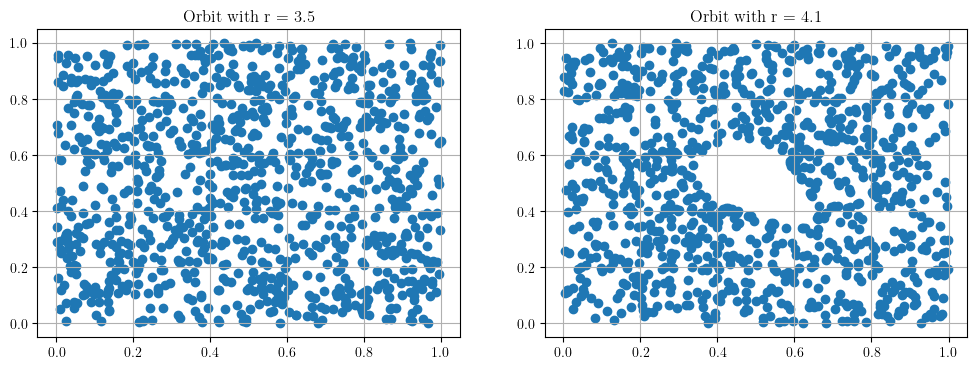

In [36]:
r1, r2 = 3.5, 4.1

traj1 = u.generate_orbit(1000, r=r1)
traj2 = u.generate_orbit(1000, r=r2)

fig, axs = plt.subplots(1, 2, figsize=(12,4))
for ax, traj, r in zip(axs, [traj1, traj2], [r1, r2]):
    ax.scatter(traj[:,0], traj[:,1])
    ax.grid()
    ax.set_title("Orbit with r = %s" %r)

**<span style="color:blue">Exercise:</span>** Explore how TDA can help discriminating orbits with respect to the parameter $r$. 
For instance, you can sample various orbits with $r=3.5$ and others with $r=4.1$ and design a simple method based on TDA to discriminate between these two models. 
Another interesting track is to look at the evolution of some quantity of interest (e.g. the _total persistence_, see Section III. 4) with respect to the parameter $r$. 

This is an open exercise, there is no specific answer expected! Just play with the tools at your disposal, and you may have funny and creative ideas!

## 2. Recognizing motions

In the following, we will retrieve times series corresponding to magnetometer data of a person undergoing through four different activities. 
The dataset is made of 4 classes: `walking`, `stepper`, `cross`, `jumping`. 
For each class, we have access to $10$ realizations, each realization being a $3$-dimensional time series of length $1500$. 

We give you a convenient loader for the data. It also shows you a sample of each class (with an index between 0 and 9 for each class). 

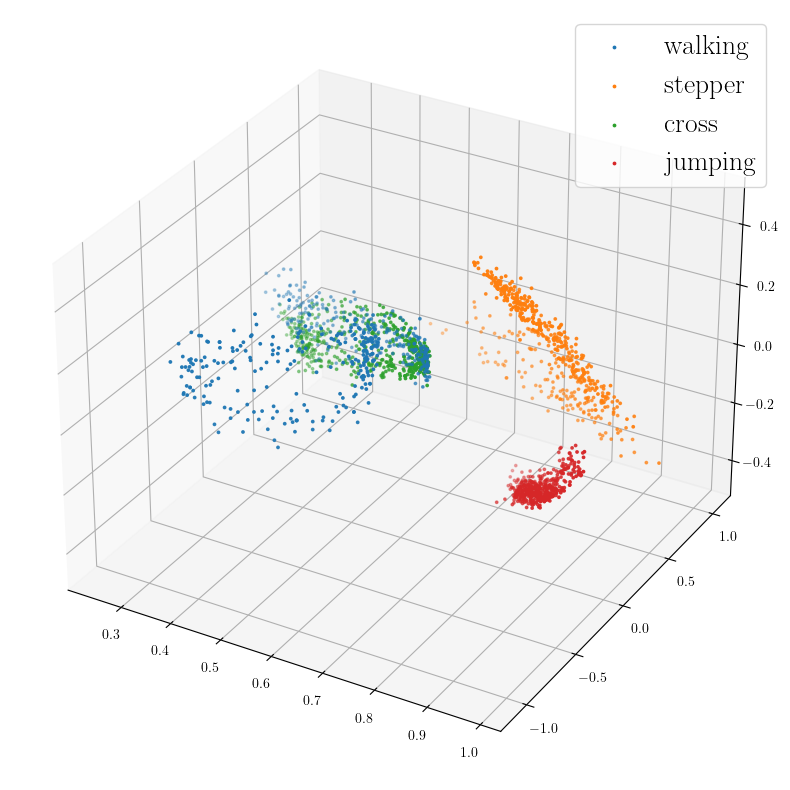

In [37]:
walkers, steppers, runners, jumpers = u.load_data_motions(idx = 9)  # change idx (between 0 and 9) to see a different instance for each class.

**<span style="color:blue">Exercise:</span>** Relying on TDA methods, show that you can distinguish time series belonging to the four different classes using their persistence diagrams. 

Here as well, this is an open question with no precise answer expected; just "convince" you (and us) that TDA can separate these different kind of objects!

In [38]:
# Write your code here.

----

# V. To go further: some questions before the MRC.

## 1. Minimal representative cycles

See for instance [this request](https://github.com/GUDHI/gudhi-devel/issues/812) on `Gudhi`'s github page.

## 2. Filtrations for dynamical systems